In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
from typing import Set, Union
from collections import Counter
from tqdm import tqdm

# Router Measurement

## Question 1.1

Researchers often summarize a large collection of measurement data using distribution functions. Imagine you have a list of Web pages with different sizes, in terms of number of bytes. The cumulative distribution function (CDF) of page sizes would have a y-axis of "the fraction of Web pages that are less than or equal to x bytes", and an x-axis of the number of bytes. The graph would start at y=0, since no Web pages have less than or equal to 0 bytes, and reach y=1 when x reaches the size of the largest page.

Create a CDF where the x-axis is the number of bytes in a flow, and the y-axis is the percentage of flows with that many bytes or less. Make this same plot but for flows transported by UDP and TCP. Provide two observations about trends or patterns you can determine from this graph. Make sure to use logarithmic scales for x-axis and linear scale for y-axis for figures to be clear.

In [2]:
# Load csv dataframe
netflow_df = pd.read_csv('netflow.csv')
netflow_df.head()

,Date first seen,Time first seen (m:s),Date last seen,Time last seen (m:s),Duration (s),Protocol,Src IP addr,Src port,Dst IP addr,Dst port,Packets,Bytes,Flags,Input interface,Output interface
0,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,116.211.0.90,52704,128.112.186.67,9095.0,1,40,....S.,120,70
1,10/29/15,04:48.9,10/29/15,04:48.9,0.0,ICMP,172.16.241.1,0,128.112.213.189,11.0,1,94,.A....,120,0
2,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,74.82.47.46,35069,128.112.248.244,6379.0,1,40,....S.,118,70
3,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,116.211.0.90,52704,128.112.186.124,9047.0,1,40,....S.,120,70
4,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,202.75.54.174,443,128.112.244.229,51444.0,1,44,.A..S.,120,70


In [3]:
# split into TCP and UDP
tcp_netflow_df = netflow_df[netflow_df['Protocol'] == 'TCP']
udp_netflow_df = netflow_df[netflow_df['Protocol'] == 'UDP']

len(tcp_netflow_df), len(udp_netflow_df)

(73494, 27384)

In [28]:
def convert_pmf_to_cdf(sorted_stats_dict : pd.core.series.Series) -> pd.core.series.Series:
    cumulative_bytes_flow : int = 0
    total_bytes_flow : int = sorted_stats_dict.sum()
    sorted_cdf_dict : pd.core.series.Series = pd.Series({})
    for bytes_num, bytes_flow in sorted_stats_dict.items():
        cumulative_bytes_flow += bytes_flow
        sorted_cdf_dict = pd.concat([sorted_cdf_dict, pd.Series({bytes_num : float(cumulative_bytes_flow) / float(total_bytes_flow)})])
    return sorted_cdf_dict

In [29]:
def graph_cdf(sorted_cdf_dict : pd.core.series.Series, x_label : str, y_label : str, plot_name : str, 
x_is_log : bool =True, y_is_log : bool =False, manipulate_x_ticks : bool =True, continuous : bool = False, linear : bool = True) -> None:
    plt.figure(figsize=(10, 6))

    if continuous:
        plot_cdf_x = sorted_cdf_dict.index
        plot_cdf_y = sorted_cdf_dict.values
    else:
        plot_cdf_x = [0]
        plot_cdf_y = [0]
        for index, value in sorted_cdf_dict.items():
            plot_cdf_x.append(index)
            plot_cdf_y.append(plot_cdf_y[-1])
            plot_cdf_x.append(index)
            plot_cdf_y.append(value)
    if linear:
        plt.plot(plot_cdf_x, plot_cdf_y, marker='.', linestyle='-')
    else:
        plt.bar(plot_cdf_x, plot_cdf_y)
    if x_is_log:
        plt.xscale('log')  # Set x-axis to logarithmic scale
    if y_is_log:
        plt.yscale('log')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if manipulate_x_ticks:
        x_ticks = np.linspace(min(sorted_cdf_dict.index), max(sorted_cdf_dict.index), num=10)
        plt.xticks(x_ticks, x_ticks, rotation=45)
        plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        # plt.xticks(plot_cdf_x, plot_cdf_x, rotation=45)
    # plt.yticks(np.linspace(0, 1, num=20))
    plt.title(plot_name)
    plt.grid(True)
    plt.savefig('./graphs/' + plot_name + ".png")
    plt.show()

In [6]:
# create helper function for graph

def create_cdf(netflow_dataframe : pd.core.frame.DataFrame, is_tcp : bool = False, is_udp : bool = False) -> None:
    # sort the dataframe based on number of bytes transferred
    bytes_value_counts = netflow_dataframe['Bytes'].value_counts()
    sorted_bytes_value_counts = bytes_value_counts.sort_index(ascending=True)
    sorted_cdf = convert_pmf_to_cdf(sorted_bytes_value_counts)
    graph_cdf(sorted_cdf, 'Bytes Number (log scale)', 'Percentage of Flow (linear scale)', 
    "TCP_Netflow_Cumulative_Distribution_Function_Plot" if is_tcp else ("UDP_Netflow_Cumulative_Distribution_Function_Plot" if is_udp else "All Netflow_Cumulative_Distribution_Function_Plot"))

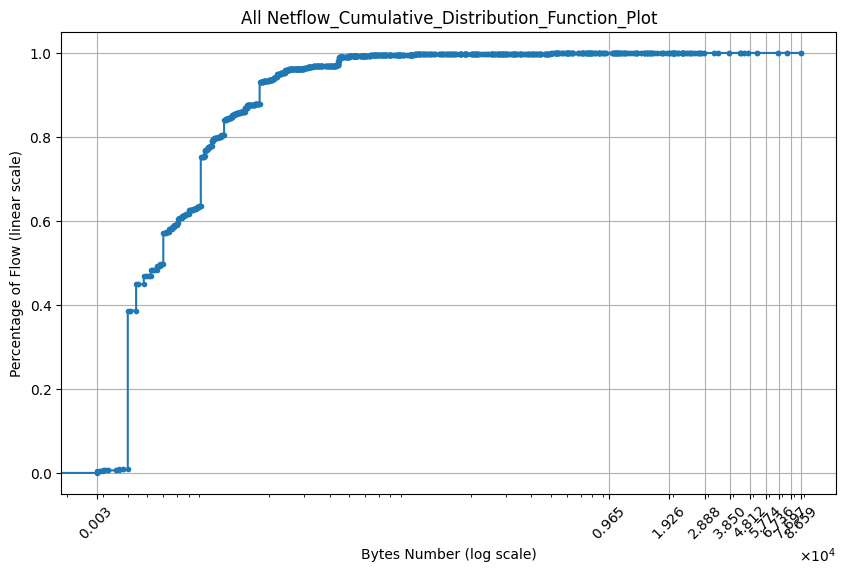

In [7]:
create_cdf(netflow_df)

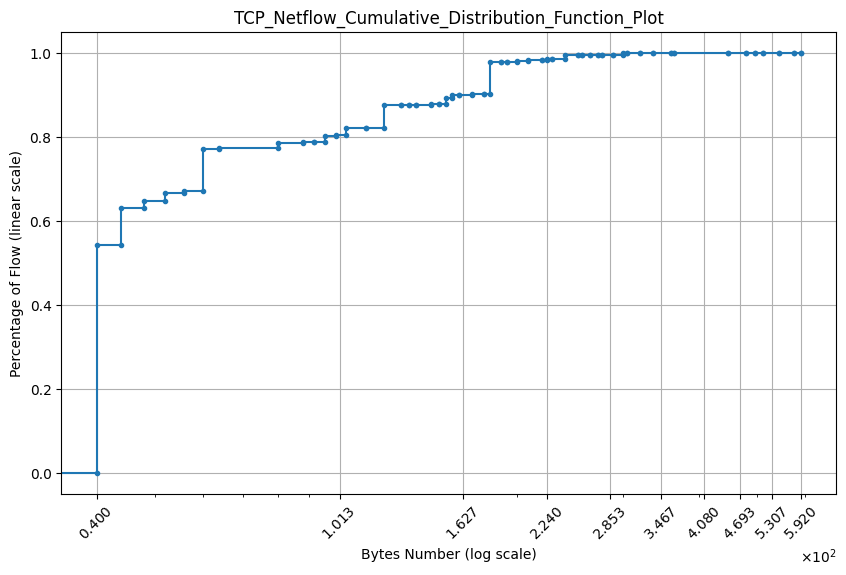

In [8]:
create_cdf(tcp_netflow_df, is_tcp=True)

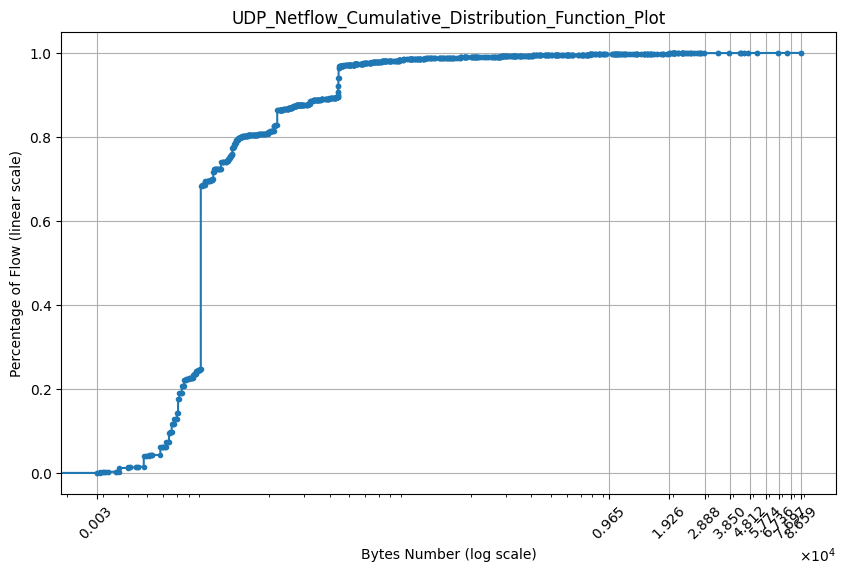

In [8]:
create_cdf(udp_netflow_df, is_udp=True)

## Question 1.2

Get the number of flows for each source IP address, only considering its 16-bit prefix (for example: the IP addresses 255.255.0.1 and 255.255.0.2 are counted as there being two 255.255 addresses). What are the top ten IP address prefixes, and what percentage of all the flows recorded are they involved in? (No need to report the percentage per source IP address, just report the aggreagate percentage for top ten source IP addresses.)

Now, aggregate the number of bytes by source IP addresses the same way. What are the top ten IP address prefixes in this case, and what percentage of bytes sent across all flows are they responsible for (no need to report the percentage per source IP address, just report the aggreagate percentage for top ten source IP addresses)?

In [9]:
# recheck the whole dataframe
netflow_df.head()

,Date first seen,Time first seen (m:s),Date last seen,Time last seen (m:s),Duration (s),Protocol,Src IP addr,Src port,Dst IP addr,Dst port,Packets,Bytes,Flags,Input interface,Output interface
0,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,116.211.0.90,52704,128.112.186.67,9095.0,1,40,....S.,120,70
1,10/29/15,04:48.9,10/29/15,04:48.9,0.0,ICMP,172.16.241.1,0,128.112.213.189,11.0,1,94,.A....,120,0
2,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,74.82.47.46,35069,128.112.248.244,6379.0,1,40,....S.,118,70
3,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,116.211.0.90,52704,128.112.186.124,9047.0,1,40,....S.,120,70
4,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,202.75.54.174,443,128.112.244.229,51444.0,1,44,.A..S.,120,70


In [10]:
# create a new column with only the 16-bit prefix
netflow_df['Src IP addr /16 prefix'] = netflow_df['Src IP addr'].map(lambda addr : '.'.join(addr.split('.')[:2]) + '.0.0')

In [11]:
# check the new column
netflow_df.head()

,Date first seen,Time first seen (m:s),Date last seen,Time last seen (m:s),Duration (s),Protocol,Src IP addr,Src port,Dst IP addr,Dst port,Packets,Bytes,Flags,Input interface,Output interface,Src IP addr /16 prefix
0,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,116.211.0.90,52704,128.112.186.67,9095.0,1,40,....S.,120,70,116.211.0.0
1,10/29/15,04:48.9,10/29/15,04:48.9,0.0,ICMP,172.16.241.1,0,128.112.213.189,11.0,1,94,.A....,120,0,172.16.0.0
2,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,74.82.47.46,35069,128.112.248.244,6379.0,1,40,....S.,118,70,74.82.0.0
3,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,116.211.0.90,52704,128.112.186.124,9047.0,1,40,....S.,120,70,116.211.0.0
4,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,202.75.54.174,443,128.112.244.229,51444.0,1,44,.A..S.,120,70,202.75.0.0


In [12]:
# check the statistics for the new column
src_ip_16_prefix_stats = netflow_df['Src IP addr /16 prefix'].value_counts()
src_ip_16_prefix_stats = src_ip_16_prefix_stats.sort_values(ascending=False)
src_ip_16_prefix_stats[:10]

Src IP addr /16 prefix
116.211.0.0    17019
169.54.0.0      9424
222.186.0.0     5269
163.53.0.0      2981
169.45.0.0      2494
94.23.0.0       2205
141.212.0.0     2143
212.83.0.0      2042
64.125.0.0      1852
184.105.0.0     1775
Name: count, dtype: int64

In [13]:
# create a dataframe from this
total_flows = src_ip_16_prefix_stats.sum()
src_ip_16_prefix_probs = src_ip_16_prefix_stats.apply(lambda count: float(count) / float(total_flows))
src_ip_16_prefix_probs [:10]

Src IP addr /16 prefix
116.211.0.0    0.161532
169.54.0.0     0.089446
222.186.0.0    0.050009
163.53.0.0     0.028293
169.45.0.0     0.023671
94.23.0.0      0.020928
141.212.0.0    0.020340
212.83.0.0     0.019381
64.125.0.0     0.017578
184.105.0.0    0.016847
Name: count, dtype: float64

In [14]:
# get the top ten percentage
top_10_percentage = src_ip_16_prefix_probs[:10].sum()
print(f"the top ten src ip addresses are responsible for {format(top_10_percentage  * 100, '.4f')} percent of the flows")

the top ten src ip addresses are responsible for 44.8026 percent of the flows


In [15]:
total_bytes_per_src_ip = netflow_df.groupby('Src IP addr /16 prefix')['Bytes'].sum()

sorted_bytes_per_src_ip = total_bytes_per_src_ip.sort_values(ascending=False)
sorted_bytes_per_src_ip = pd.DataFrame(sorted_bytes_per_src_ip.reset_index(), columns=['Src IP addr /16 prefix', 'Bytes'])
sorted_bytes_per_src_ip

,Src IP addr /16 prefix,Bytes
0,212.83.0.0,928311
1,169.54.0.0,867928
2,116.211.0.0,680922
3,140.205.0.0,510833
4,128.112.0.0,506604
...,...,...
8945,119.198.0.0,28
8946,181.23.0.0,28
8947,182.176.0.0,28
8948,119.122.0.0,28


In [16]:
total_bytes = total_bytes_per_src_ip.sum()
total_bytes

12051820

In [17]:
sorted_bytes_per_src_ip['Bytes Percentage'] = sorted_bytes_per_src_ip['Bytes'].map(lambda x : float(x) / float(total_bytes))
sorted_bytes_per_src_ip.head(10)

,Src IP addr /16 prefix,Bytes,Bytes Percentage
0,212.83.0.0,928311,0.077027
1,169.54.0.0,867928,0.072016
2,116.211.0.0,680922,0.056500
3,140.205.0.0,510833,0.042386
4,128.112.0.0,506604,0.042035
5,42.120.0.0,326122,0.027060
6,169.45.0.0,229448,0.019038
7,222.186.0.0,211068,0.017513
8,5.8.0.0,126940,0.010533
9,163.53.0.0,120920,0.010033


In [18]:
total_bytes_percentage = sorted_bytes_per_src_ip.iloc[:10]['Bytes Percentage'].sum()
print(f"the top ten src ip addresses are responsible for {format(total_bytes_percentage  * 100, '.4f')} percent of the bytes transferred")

the top ten src ip addresses are responsible for 37.4142 percent of the bytes transferred


## Question 1.3

The src/dst port number of a connection corresponds to the src/dst port number for a UDP/TCP packet. This number represents the application protocol that the packet either came from or is sent to. See this wikipedia page for more information on what these port numbers mean.

Pick a port number less than 1024, provide the type of service it's associated with, and report the percentage of flows it appears in as the src port and the percentage of flows it appears in as the dst port.

In [19]:
# recheck the whole dataframe
# netflow_df = netflow_df.drop(columns=['Src IP addr /16 prefix'])

# for some reason the read-in Dst port are all floats so convert to integer
netflow_df['Dst port'] = netflow_df['Dst port'].map(lambda x : int(x))
netflow_df.head()

,Date first seen,Time first seen (m:s),Date last seen,Time last seen (m:s),Duration (s),Protocol,Src IP addr,Src port,Dst IP addr,Dst port,Packets,Bytes,Flags,Input interface,Output interface,Src IP addr /16 prefix
0,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,116.211.0.90,52704,128.112.186.67,9095,1,40,....S.,120,70,116.211.0.0
1,10/29/15,04:48.9,10/29/15,04:48.9,0.0,ICMP,172.16.241.1,0,128.112.213.189,11,1,94,.A....,120,0,172.16.0.0
2,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,74.82.47.46,35069,128.112.248.244,6379,1,40,....S.,118,70,74.82.0.0
3,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,116.211.0.90,52704,128.112.186.124,9047,1,40,....S.,120,70,116.211.0.0
4,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,202.75.54.174,443,128.112.244.229,51444,1,44,.A..S.,120,70,202.75.0.0


In [20]:
# let's just randomly generate a port number
random.seed(42)
random_port = 1024
while (random_port >= 1024):
    random_port_row = random.randrange(0, len(netflow_df))
    src_or_dst = random.uniform(0, 1)
    random_port = netflow_df.iloc[random_port_row]['Src port' if src_or_dst > 0.5 else 'Dst port']
print(f"The random port number picked is : {random_port}")

The random port number picked is : 23


[reference website](https://www.giac.org/paper/gcih/328/tcp-port-23/103233)

Port 23 is typically used by the Telnet protocol. Telnet commonly provides remote access to a variety of communications systems. Telnet is also often used for remote maintenance of many networking communications devices including routers and switches. Unlike many other common protocols, like HTTP or FTP, telnet often provides access to a remote system with administrator privileges. Given access to a server, or a network router of a corporate network or ISP, an attacker can perform a great deal of mischief. The level of access provided by telnet makes it a valuable commodity for individuals attempting to gain unauthorized access to systems or networks. This makes port 23 a very common target of attackers during network scans and reconnaissance attempts.

In [21]:
# calculate the statistics of port number 228
filtered_src_port_df = netflow_df[netflow_df['Src port'] == random_port]
filtered_dst_port_df = netflow_df[netflow_df['Dst port'] == random_port]

print(f"The random port number studied is {random_port}.")
print(f"The percentage of flows it appears in as the src port is {format(float(len(filtered_src_port_df)) / float(len(netflow_df)) * 100, '.4f')} percent.")
print(f"and the percentage of flows it appears in as the dst port is {format(float(len(filtered_dst_port_df)) / float(len(netflow_df)) * 100, '.4f')} percent.")

The random port number studied is 23.
The percentage of flows it appears in as the src port is 0.1509 percent.
and the percentage of flows it appears in as the dst port is 18.4007 percent.


## Question 1.4

Observe that this router is responsible for the address block 128.112.0.0/16. What percentage of bytes is sent from this router, and what percentage is sent to this router? What percentage of bytes have a destination and source IP address that are both in this address block? What do these metrics tell you about traffic happening with this router?

In [22]:
# recheck the whole dataframe
netflow_df.head()

,Date first seen,Time first seen (m:s),Date last seen,Time last seen (m:s),Duration (s),Protocol,Src IP addr,Src port,Dst IP addr,Dst port,Packets,Bytes,Flags,Input interface,Output interface,Src IP addr /16 prefix
0,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,116.211.0.90,52704,128.112.186.67,9095,1,40,....S.,120,70,116.211.0.0
1,10/29/15,04:48.9,10/29/15,04:48.9,0.0,ICMP,172.16.241.1,0,128.112.213.189,11,1,94,.A....,120,0,172.16.0.0
2,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,74.82.47.46,35069,128.112.248.244,6379,1,40,....S.,118,70,74.82.0.0
3,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,116.211.0.90,52704,128.112.186.124,9047,1,40,....S.,120,70,116.211.0.0
4,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,202.75.54.174,443,128.112.244.229,51444,1,44,.A..S.,120,70,202.75.0.0


In [23]:
# create new columns with only the 16-bit prefix
netflow_df['Src IP addr /16 prefix'] = netflow_df['Src IP addr'].map(lambda addr : '.'.join(addr.split('.')[:2]) + '.0.0')
netflow_df['Dst IP addr /16 prefix'] = netflow_df['Dst IP addr'].map(lambda addr : '.'.join(addr.split('.')[:2]) + '.0.0')
netflow_df.head()

,Date first seen,Time first seen (m:s),Date last seen,Time last seen (m:s),Duration (s),Protocol,Src IP addr,Src port,Dst IP addr,Dst port,Packets,Bytes,Flags,Input interface,Output interface,Src IP addr /16 prefix,Dst IP addr /16 prefix
0,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,116.211.0.90,52704,128.112.186.67,9095,1,40,....S.,120,70,116.211.0.0,128.112.0.0
1,10/29/15,04:48.9,10/29/15,04:48.9,0.0,ICMP,172.16.241.1,0,128.112.213.189,11,1,94,.A....,120,0,172.16.0.0,128.112.0.0
2,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,74.82.47.46,35069,128.112.248.244,6379,1,40,....S.,118,70,74.82.0.0,128.112.0.0
3,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,116.211.0.90,52704,128.112.186.124,9047,1,40,....S.,120,70,116.211.0.0,128.112.0.0
4,10/29/15,04:48.9,10/29/15,04:48.9,0.0,TCP,202.75.54.174,443,128.112.244.229,51444,1,44,.A..S.,120,70,202.75.0.0,128.112.0.0


In [26]:
ROUTER_INTEREST = '128.112.0.0'
netflow_src_in_router = netflow_df[netflow_df['Src IP addr /16 prefix'] == ROUTER_INTEREST]['Bytes'].sum()
netflow_dst_in_router = netflow_df[netflow_df['Dst IP addr /16 prefix'] == ROUTER_INTEREST]['Bytes'].sum()
netflow_both_in_router = netflow_df[(netflow_df['Src IP addr /16 prefix'] == ROUTER_INTEREST) & (netflow_df['Dst IP addr /16 prefix'] == ROUTER_INTEREST)]['Bytes'].sum()
total_bytes = netflow_df['Bytes'].sum()

In [27]:
print(f"percentage of bytes that is sent from this router is {format(float(netflow_src_in_router) / float(total_bytes) * 100, '.4f')} percent.")
print(f"percentage of bytes that is sent to this router is {format(float(netflow_dst_in_router) / float(total_bytes) * 100, '.4f')} percent.")
print(f"percentage of bytes that have a destination and source IP address that are both in this address block is {format(float(netflow_both_in_router) / float(total_bytes) * 100, '.4f')} percent.")

percentage of bytes that is sent from this router is 4.2035 percent.
percentage of bytes that is sent to this router is 95.9478 percent.
percentage of bytes that have a destination and source IP address that are both in this address block is 0.8353 percent.


This shows that the majority of the traffic comes into the router but does not come out.

## Question 1.5

The data you worked with comes from a university's campus, from 6:05 AM to 6:10 AM. What changes would expect in your answers for the previous questions if this data was collected from a router that was serving devices at a busy public cafe during the afternoon? Provide reasons as to why.

# BGP Measurement

In [16]:
MAX_AS_NUM = 2 ** 32
MAX_AS_NUM

4294967296

In [17]:
# read in the csv files
bgp_route_df = pd.read_csv('bgp_route.csv')
bgp_route_df.head()

,TIME,NEXT_HOP,FROM,ASPATH,PREFIX,ORIGIN
0,3/28/2021 4:00,85.114.0.217,194.153.0.253 AS5413,286 3257 13335,1.0.0.0/24,IGP
1,3/28/2021 4:00,202.73.40.45,12.0.1.63 AS7018,3303 6939 4826 38803,1.0.4.0/24,IGP
2,3/28/2021 4:00,94.156.252.18,212.66.96.126 AS20912,49788 6939 4826 38803,1.0.5.0/24,IGP
3,3/28/2021 4:00,202.73.40.45,45.61.0.85 AS22652,3130 2497 2519,1.0.16.0/24,IGP
4,3/28/2021 4:00,194.153.0.253,208.51.134.255 AS3549,3549 3356 2516 2519,1.0.16.0/24,IGP


In [18]:
bgp_update_df = pd.read_csv('bgp_update.csv')
bgp_update_df.head()

,TIME,FROM,ASPATH,NEXT_HOP,COMMAND,ORIGIN
0,45:00.3,208.51.134.246 AS3549,3549 3356 8820 8820 8820 8820,208.51.134.246,ANNOUNCE 46.41.11.0/24,IGP
1,45:00.3,12.0.1.63 AS7018,NaN,NaN,WITHDRAW 103.211.81.0/24,NaN
2,45:00.3,62.115.129.4 AS1299,1299 6939 6939 136168 136168 136168 141015,62.115.129.4,ANNOUNCE 103.154.240.0/23,IGP
3,45:00.3,62.115.129.4 AS1299,1299 6939 6939 23947 45306 137359,62.115.129.4,ANNOUNCE 103.115.39.0/24 103.115.37.0/24,IGP
4,45:00.3,62.115.129.4 AS1299,1299 136106 136106 136106 38753,62.115.129.4,ANNOUNCE 103.16.114.0/23,IGP


## Question 2.1

From the bgp_route.csv, what are the 10 most frequent ASes in all the BGP paths? What percentage of paths are they found in? Using your favorite browser and search engine, give the name of the AS and the country they belong to (Hint: search for "AS number lookup", give the country's full name). Why might it be problematic for an AS to be commonly found in these routes?

In [19]:
def create_ASPATH_set(AS_path : Union[str, float]) -> Set:
    if pd.isna(AS_path):
        return set({})
    AS_path_list = AS_path.split(" ")
    AS_path_cleaned_list = []
    for AS_path in AS_path_list:
        if AS_path[0] == '{':
            AS_subpath_list = AS_path[1:-1].split(",")
            cleaned_AS_subpath_list = []
            for subpath in AS_subpath_list:
                if ~pd.isna(subpath):
                    cleaned_AS_subpath_list.append(int(subpath))
            AS_path_cleaned_list.extend(cleaned_AS_subpath_list)
        else:
            AS_path_cleaned_list.append(int(AS_path))
    AS_path_set = set(AS_path_cleaned_list )
    return AS_path_set

In [20]:
bgp_route_df['ASPATH Set'] = bgp_route_df['ASPATH'].map(lambda x: create_ASPATH_set(x))
bgp_route_df.head()

,TIME,NEXT_HOP,FROM,ASPATH,PREFIX,ORIGIN,ASPATH Set
0,3/28/2021 4:00,85.114.0.217,194.153.0.253 AS5413,286 3257 13335,1.0.0.0/24,IGP,"{3257, 286, 13335}"
1,3/28/2021 4:00,202.73.40.45,12.0.1.63 AS7018,3303 6939 4826 38803,1.0.4.0/24,IGP,"{4826, 6939, 38803, 3303}"
2,3/28/2021 4:00,94.156.252.18,212.66.96.126 AS20912,49788 6939 4826 38803,1.0.5.0/24,IGP,"{4826, 6939, 49788, 38803}"
3,3/28/2021 4:00,202.73.40.45,45.61.0.85 AS22652,3130 2497 2519,1.0.16.0/24,IGP,"{2497, 3130, 2519}"
4,3/28/2021 4:00,194.153.0.253,208.51.134.255 AS3549,3549 3356 2516 2519,1.0.16.0/24,IGP,"{2516, 3356, 3549, 2519}"


In [21]:
def AS_freq_counter(router_dataframe : pd.core.frame.DataFrame) -> Counter:
    counter = Counter()

    for s in router_dataframe['ASPATH Set']:
        counter.update(s)
    
    return counter


In [22]:
AS_counter = AS_freq_counter(bgp_route_df)
ten_most_freq_AS = AS_counter.most_common(10)
ten_most_freq_AS

[(3356, 95483),
 (3257, 75208),
 (1299, 64771),
 (6939, 56415),
 (2914, 54290),
 (37100, 45399),
 (174, 45319),
 (49788, 41468),
 (3130, 38180),
 (3303, 36486)]

In [23]:
total_ASPATH = len(bgp_route_df)
ten_most_freq_AS_probs = [(k, format(float(v) / float(total_ASPATH) * 100, '.4f') + '%') for (k, v) in ten_most_freq_AS]
ten_most_freq_AS_probs

[(3356, '19.6301%'),
 (3257, '15.4618%'),
 (1299, '13.3161%'),
 (6939, '11.5982%'),
 (2914, '11.1613%'),
 (37100, '9.3334%'),
 (174, '9.3170%'),
 (49788, '8.5253%'),
 (3130, '7.8493%'),
 (3303, '7.5010%')]

3356 : LEVEL3, US
3257 : GTT-BACKBONE GTT, US
1299 : TWELVE99 Arelion, fka Telia Carrier, SE
6939 : HURRICANE, US
2914 : NTT-LTD-2914, US
37100 : SEACOM-AS, MU
174 : COGENT-174, US
49788 : NEXTHOP, NO
3130 : RGNET-SEA RGnet Seattle Westin, EE
3303 : SWISSCOM Swisscom Switzerland Ltd, CH

## Question 2.2

Plot a cumulative distribution function (CDF) where the x-axis is the length of a BGP path and y-axis is the proportion of the paths with that length or less. The length is the number of unique ASes in an entry's ASPATH. What does this graph tell you about BGP route lengths? What does this graph tell you about a packet’s travel across the internet?

In [24]:
bgp_route_df.head()

,TIME,NEXT_HOP,FROM,ASPATH,PREFIX,ORIGIN,ASPATH Set
0,3/28/2021 4:00,85.114.0.217,194.153.0.253 AS5413,286 3257 13335,1.0.0.0/24,IGP,"{3257, 286, 13335}"
1,3/28/2021 4:00,202.73.40.45,12.0.1.63 AS7018,3303 6939 4826 38803,1.0.4.0/24,IGP,"{4826, 6939, 38803, 3303}"
2,3/28/2021 4:00,94.156.252.18,212.66.96.126 AS20912,49788 6939 4826 38803,1.0.5.0/24,IGP,"{4826, 6939, 49788, 38803}"
3,3/28/2021 4:00,202.73.40.45,45.61.0.85 AS22652,3130 2497 2519,1.0.16.0/24,IGP,"{2497, 3130, 2519}"
4,3/28/2021 4:00,194.153.0.253,208.51.134.255 AS3549,3549 3356 2516 2519,1.0.16.0/24,IGP,"{2516, 3356, 3549, 2519}"


In [25]:
bgp_route_df['ASPATH length'] = bgp_route_df['ASPATH Set'].map(lambda s : len(s))
bgp_route_df.head()

,TIME,NEXT_HOP,FROM,ASPATH,PREFIX,ORIGIN,ASPATH Set,ASPATH length
0,3/28/2021 4:00,85.114.0.217,194.153.0.253 AS5413,286 3257 13335,1.0.0.0/24,IGP,"{3257, 286, 13335}",3
1,3/28/2021 4:00,202.73.40.45,12.0.1.63 AS7018,3303 6939 4826 38803,1.0.4.0/24,IGP,"{4826, 6939, 38803, 3303}",4
2,3/28/2021 4:00,94.156.252.18,212.66.96.126 AS20912,49788 6939 4826 38803,1.0.5.0/24,IGP,"{4826, 6939, 49788, 38803}",4
3,3/28/2021 4:00,202.73.40.45,45.61.0.85 AS22652,3130 2497 2519,1.0.16.0/24,IGP,"{2497, 3130, 2519}",3
4,3/28/2021 4:00,194.153.0.253,208.51.134.255 AS3549,3549 3356 2516 2519,1.0.16.0/24,IGP,"{2516, 3356, 3549, 2519}",4


In [26]:
# create helper function for graph
def create_AS_path_cdf(AS_dataframe : pd.core.frame.DataFrame) -> None:
    AS_pathlen_counts = AS_dataframe['ASPATH length'].value_counts()
    sorted_AS_pathlen_counts = AS_pathlen_counts.sort_index(ascending=True)
    sorted_cdf = convert_pmf_to_cdf(sorted_AS_pathlen_counts)
    graph_cdf(sorted_cdf, 'Unique AS Number (linear scale)', 'Percentage of Path (linear scale)', 
    "AS_Path_Length_Cumulative_Distribution_Function_Plot", x_is_log=False, manipulate_x_ticks=False)

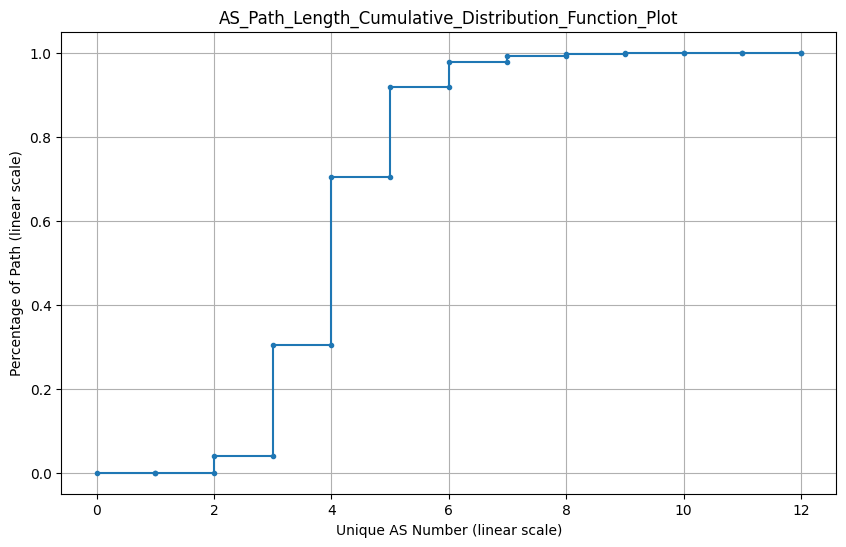

In [30]:
create_AS_path_cdf(bgp_route_df)

It shows that the majority of AS path has 3 - 6 unique autonomous systems. 

## Question 2.3

Using bgp_updates.csv, how many BGP updates are done per minute, on average? Make a graph where the x-axis is time and the y-axis is the number of updates at that second.

In [31]:
bgp_update_df.head()

,TIME,FROM,ASPATH,NEXT_HOP,COMMAND,ORIGIN
0,45:00.3,208.51.134.246 AS3549,3549 3356 8820 8820 8820 8820,208.51.134.246,ANNOUNCE 46.41.11.0/24,IGP
1,45:00.3,12.0.1.63 AS7018,NaN,NaN,WITHDRAW 103.211.81.0/24,NaN
2,45:00.3,62.115.129.4 AS1299,1299 6939 6939 136168 136168 136168 141015,62.115.129.4,ANNOUNCE 103.154.240.0/23,IGP
3,45:00.3,62.115.129.4 AS1299,1299 6939 6939 23947 45306 137359,62.115.129.4,ANNOUNCE 103.115.39.0/24 103.115.37.0/24,IGP
4,45:00.3,62.115.129.4 AS1299,1299 136106 136106 136106 38753,62.115.129.4,ANNOUNCE 103.16.114.0/23,IGP


In [32]:
bgp_update_df['TIME_reorganized_by_sec'] = bgp_update_df['TIME'].map(lambda x : int(x.split(':')[0]) * 60 + round(float(x.split(':')[1])))
bgp_update_df['TIME_reorganized_by_min'] = bgp_update_df['TIME_reorganized_by_sec'].map(lambda x : round(x / 60))
bgp_update_df.sort_values(by='TIME_reorganized_by_sec', ascending=True)

,TIME,FROM,ASPATH,NEXT_HOP,COMMAND,ORIGIN,TIME_reorganized_by_sec,TIME_reorganized_by_min
166258,00:00.2,137.39.3.55 AS701,NaN,NaN,WITHDRAW 168.243.93.0/24,NaN,0,0
166230,00:00.0,91.218.184.60 AS49788,49788 1299 6453 9829,91.218.184.60,ANNOUNCE 117.225.112.0/20 117.225.128.0/20 117...,IGP,0,0
166229,00:00.0,91.218.184.60 AS49788,49788 1299 6453 9829,91.218.184.60,ANNOUNCE 59.97.248.0/22 59.97.196.0/22 59.90.1...,IGP,0,0
166228,00:00.0,62.115.129.4 AS1299,1299 38158 38158 38158 17670,62.115.129.4,ANNOUNCE 103.213.129.0/24,IGP,0,0
166227,00:00.0,62.115.129.4 AS1299,1299 9902 135273 24088,62.115.129.4,ANNOUNCE 203.128.242.0/23,IGP,0,0
...,...,...,...,...,...,...,...,...
166167,59:59.8,147.28.7.2 AS3130,3130 1239 6453 9829 135848,147.28.7.2,ANNOUNCE 103.81.156.0/22,IGP,3600,60
166168,59:59.8,147.28.7.2 AS3130,3130 1239 6453 9829 133725,147.28.7.2,ANNOUNCE 103.142.16.0/23,IGP,3600,60
166169,59:59.8,147.28.7.2 AS3130,3130 1239 6453 9829,147.28.7.2,ANNOUNCE 59.97.196.0/22 59.97.248.0/22 117.225...,IGP,3600,60
166163,59:59.7,91.218.184.60 AS49788,49788 12552 38195 24233 24093 7631 7631 7631,91.218.184.60,ANNOUNCE 123.176.112.0/23,IGP,3600,60


In [33]:
# notice that 0 seems to be an outlier. Eliminate 0 rows
bgp_update_df_filtered = bgp_update_df[bgp_update_df['TIME_reorganized_by_min'] != 0]
bgp_update_df_filtered.head()

,TIME,FROM,ASPATH,NEXT_HOP,COMMAND,ORIGIN,TIME_reorganized_by_sec,TIME_reorganized_by_min
0,45:00.3,208.51.134.246 AS3549,3549 3356 8820 8820 8820 8820,208.51.134.246,ANNOUNCE 46.41.11.0/24,IGP,2700,45
1,45:00.3,12.0.1.63 AS7018,NaN,NaN,WITHDRAW 103.211.81.0/24,NaN,2700,45
2,45:00.3,62.115.129.4 AS1299,1299 6939 6939 136168 136168 136168 141015,62.115.129.4,ANNOUNCE 103.154.240.0/23,IGP,2700,45
3,45:00.3,62.115.129.4 AS1299,1299 6939 6939 23947 45306 137359,62.115.129.4,ANNOUNCE 103.115.39.0/24 103.115.37.0/24,IGP,2700,45
4,45:00.3,62.115.129.4 AS1299,1299 136106 136106 136106 38753,62.115.129.4,ANNOUNCE 103.16.114.0/23,IGP,2700,45


In [34]:
# create helper function for graph
def create_AS_update_bar(AS_dataframe : pd.core.frame.DataFrame, per_minute : bool = False) -> None:
    AS_update_counts = AS_dataframe['TIME_reorganized_by_min'].value_counts() if per_minute else AS_dataframe['TIME_reorganized_by_sec'].value_counts() 
    sorted_AS_update_counts = AS_update_counts.sort_index(ascending=True)
    graph_cdf(sorted_AS_update_counts, 'Time (min)' if per_minute else 'Time (sec)', 'Number of Updates', 
    "AS_Updates_Time_Statistics_Bar_Chart_Per_Min" if per_minute else "AS_Updates_Time_Statistics_Bar_Chart_Per_Sec", 
    x_is_log=False, manipulate_x_ticks=False, linear=False)

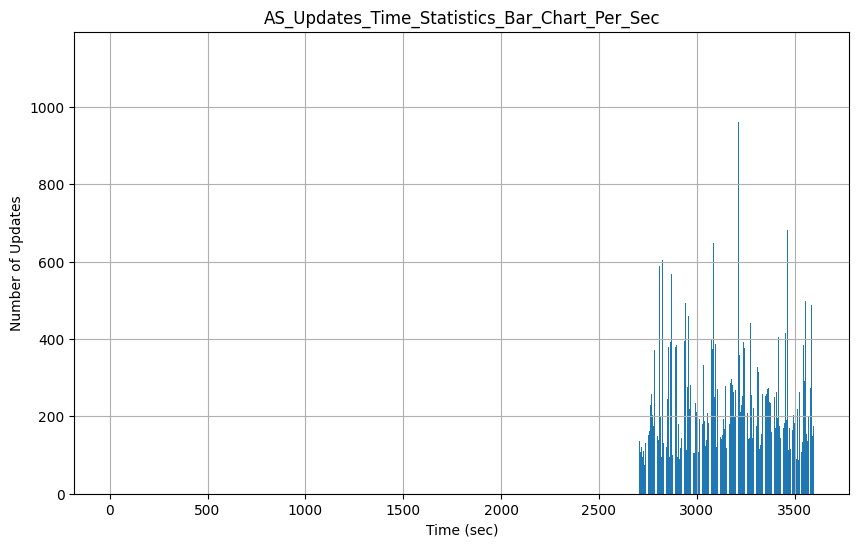

In [35]:
create_AS_update_bar(bgp_update_df_filtered)

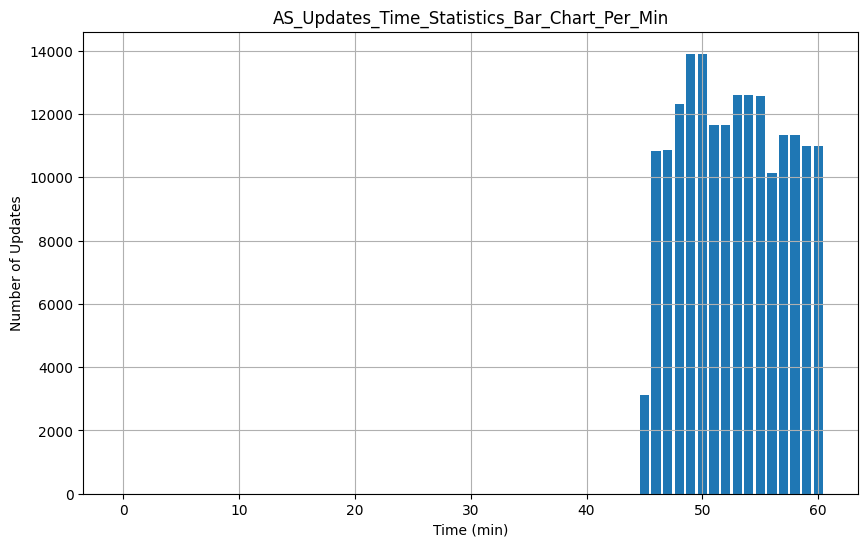

In [36]:
create_AS_update_bar(bgp_update_df_filtered, per_minute = True)

In [38]:
total_num_per_min_w_0 = float(len(bgp_update_df)) / float(16)
total_num_per_min_wo_0 = float(len(bgp_update_df_filtered)) / float(15)
total_num_per_min_w_0, total_num_per_min_wo_0

(10391.1875, 11080.533333333333)

In [39]:
print(f"Depending on whether we consider the 0 time as outlier, we can have two different results:")
print(f"if we consider the 0 as 1:00:00.0 getting overwritten, then the average would be {format(total_num_per_min_w_0, '.2f')} BGP updates are done per minute.")
print(f"however, if we consider the 0 as outliers, then the average would be {format(total_num_per_min_wo_0, '.2f')} BGP updates are done per minute.")

Depending on whether we consider the 0 time as outlier, we can have two different results:
if we consider the 0 as 1:00:00.0 getting overwritten, then the average would be 10391.19 BGP updates are done per minute.
however, if we consider the 0 as outliers, then the average would be 11080.53 BGP updates are done per minute.


## Question 2.4

Plot a CDF where the x-axis is the top percentage of ASes by the number of updates and the y-axis is the percentage of updates messages that are from that top percentage. Include all ASes from bgp_route.csv, not just the bgp_update.csv. Make sure to use logarithmic scales for graph axes if the distribution is not clear. What can you infer about the ASes tracked here, specifically about their stability?

In [50]:
bgp_route_df.head()

,TIME,NEXT_HOP,FROM,ASPATH,PREFIX,ORIGIN,ASPATH Set,ASPATH length
0,3/28/2021 4:00,85.114.0.217,194.153.0.253 AS5413,286 3257 13335,1.0.0.0/24,IGP,"{3257, 286, 13335}",3
1,3/28/2021 4:00,202.73.40.45,12.0.1.63 AS7018,3303 6939 4826 38803,1.0.4.0/24,IGP,"{4826, 6939, 38803, 3303}",4
2,3/28/2021 4:00,94.156.252.18,212.66.96.126 AS20912,49788 6939 4826 38803,1.0.5.0/24,IGP,"{4826, 6939, 49788, 38803}",4
3,3/28/2021 4:00,202.73.40.45,45.61.0.85 AS22652,3130 2497 2519,1.0.16.0/24,IGP,"{2497, 3130, 2519}",3
4,3/28/2021 4:00,194.153.0.253,208.51.134.255 AS3549,3549 3356 2516 2519,1.0.16.0/24,IGP,"{2516, 3356, 3549, 2519}",4


In [51]:
bgp_update_df.head()

,TIME,FROM,ASPATH,NEXT_HOP,COMMAND,ORIGIN,TIME_reorganized_by_sec,TIME_reorganized_by_min
0,45:00.3,208.51.134.246 AS3549,3549 3356 8820 8820 8820 8820,208.51.134.246,ANNOUNCE 46.41.11.0/24,IGP,2700,45
1,45:00.3,12.0.1.63 AS7018,NaN,NaN,WITHDRAW 103.211.81.0/24,NaN,2700,45
2,45:00.3,62.115.129.4 AS1299,1299 6939 6939 136168 136168 136168 141015,62.115.129.4,ANNOUNCE 103.154.240.0/23,IGP,2700,45
3,45:00.3,62.115.129.4 AS1299,1299 6939 6939 23947 45306 137359,62.115.129.4,ANNOUNCE 103.115.39.0/24 103.115.37.0/24,IGP,2700,45
4,45:00.3,62.115.129.4 AS1299,1299 136106 136106 136106 38753,62.115.129.4,ANNOUNCE 103.16.114.0/23,IGP,2700,45


In [52]:
bgp_route_df['Unique_AS_set'] = bgp_route_df.apply(lambda x: x['ASPATH Set'].union({int(x['FROM'].split('AS')[-1])}), axis=1)
bgp_route_df.head()

,TIME,NEXT_HOP,FROM,ASPATH,PREFIX,ORIGIN,ASPATH Set,ASPATH length,Unique_AS_set
0,3/28/2021 4:00,85.114.0.217,194.153.0.253 AS5413,286 3257 13335,1.0.0.0/24,IGP,"{3257, 286, 13335}",3,"{3257, 5413, 286, 13335}"
1,3/28/2021 4:00,202.73.40.45,12.0.1.63 AS7018,3303 6939 4826 38803,1.0.4.0/24,IGP,"{4826, 6939, 38803, 3303}",4,"{38803, 3303, 4826, 6939, 7018}"
2,3/28/2021 4:00,94.156.252.18,212.66.96.126 AS20912,49788 6939 4826 38803,1.0.5.0/24,IGP,"{4826, 6939, 49788, 38803}",4,"{20912, 38803, 4826, 6939, 49788}"
3,3/28/2021 4:00,202.73.40.45,45.61.0.85 AS22652,3130 2497 2519,1.0.16.0/24,IGP,"{2497, 3130, 2519}",3,"{2497, 3130, 22652, 2519}"
4,3/28/2021 4:00,194.153.0.253,208.51.134.255 AS3549,3549 3356 2516 2519,1.0.16.0/24,IGP,"{2516, 3356, 3549, 2519}",4,"{2516, 2519, 3356, 3549}"


In [53]:
bgp_update_df['Unique_AS_set'] = bgp_update_df.apply(lambda x : create_ASPATH_set(x['ASPATH']).union({int(x['FROM'].split('AS')[-1])}), axis=1)
bgp_update_df.head()

,TIME,FROM,ASPATH,NEXT_HOP,COMMAND,ORIGIN,TIME_reorganized_by_sec,TIME_reorganized_by_min,Unique_AS_set
0,45:00.3,208.51.134.246 AS3549,3549 3356 8820 8820 8820 8820,208.51.134.246,ANNOUNCE 46.41.11.0/24,IGP,2700,45,"{8820, 3356, 3549}"
1,45:00.3,12.0.1.63 AS7018,NaN,NaN,WITHDRAW 103.211.81.0/24,NaN,2700,45,{7018}
2,45:00.3,62.115.129.4 AS1299,1299 6939 6939 136168 136168 136168 141015,62.115.129.4,ANNOUNCE 103.154.240.0/23,IGP,2700,45,"{1299, 141015, 136168, 6939}"
3,45:00.3,62.115.129.4 AS1299,1299 6939 6939 23947 45306 137359,62.115.129.4,ANNOUNCE 103.115.39.0/24 103.115.37.0/24,IGP,2700,45,"{6939, 1299, 45306, 23947, 137359}"
4,45:00.3,62.115.129.4 AS1299,1299 136106 136106 136106 38753,62.115.129.4,ANNOUNCE 103.16.114.0/23,IGP,2700,45,"{38753, 136106, 1299}"


In [54]:
full_AS_list = list(bgp_route_df['Unique_AS_set']) + list(bgp_update_df['Unique_AS_set'])
full_AS_set = set().union(*full_AS_list)
full_AS_sorted = list(sorted(full_AS_set))
len(full_AS_set), full_AS_sorted[:10]

(56042, [1, 2, 3, 4, 5, 6, 7, 8, 9, 12])

In [55]:
bgp_update_df['FROM AS'] = bgp_update_df['FROM'].map(lambda x : x.split('AS')[-1])
update_src_as_counts = bgp_update_df['FROM AS'].value_counts()

In [56]:
update_src_as_counts.index

Index(['1299', '8492', '34224', '49788', '3549', '31019', '1403', '18106',
       '3277', '3130', '20130', '22652', '37100', '2914', '57866', '6939',
       '7018', '1221', '7660', '57463', '3741', '23673', '5413', '53767',
       '2905', '3257', '286', '11686', '24441', '2497', '2152', '20912', '293',
       '701', '3303', '3561', '11537', '6539', '1239'],
      dtype='object', name='FROM AS')

In [57]:
AS_update_counter = Counter()
AS_update_counter.update(update_src_as_counts.to_dict())

In [58]:
def create_update_pd_series(update_counter, AS_full_list):
    AS_update_series = pd.Series()

    for AS in tqdm(AS_full_list):
        if (update_counter[str(AS)] == None):
            AS_update_series[str(AS)] = 0
        else:
            AS_update_series[str(AS)] = update_counter[str(AS)]
    
    return AS_update_series

In [59]:
AS_update_series = create_update_pd_series(AS_update_counter, full_AS_sorted)
AS_update_series

  0%|          | 0/56042 [00:00<?, ?it/s]

100%|██████████| 56042/56042 [04:16<00:00, 218.33it/s]


1             0
2             0
3             0
4             0
5             0
             ..
399412        0
399428        0
399442        0
3744737447    0
4200006010    0
Length: 56042, dtype: int64

In [60]:
total_update_num = AS_update_series.sum()
sorted_AS_updates = AS_update_series.value_counts().sort_index(ascending=True)

In [61]:
sorted_AS_pmf = sorted_AS_updates.apply(lambda x : float(x)/float(total_update_num))
sorted_AS_cdf = convert_pmf_to_cdf(sorted_AS_pmf)
sorted_AS_cdf

0        0.999304
17       0.999322
74       0.999340
75       0.999358
210      0.999375
518      0.999393
765      0.999411
886      0.999429
937      0.999447
1068     0.999465
1196     0.999483
1361     0.999500
1368     0.999518
1438     0.999536
1837     0.999554
1881     0.999572
2232     0.999590
2246     0.999607
2380     0.999625
2645     0.999643
3145     0.999661
3226     0.999679
3261     0.999697
3265     0.999714
3898     0.999732
3907     0.999750
3927     0.999768
4081     0.999786
4128     0.999804
4220     0.999822
4293     0.999839
4714     0.999857
4971     0.999875
5772     0.999893
6815     0.999911
7369     0.999929
9799     0.999946
12868    0.999964
15683    0.999982
33783    1.000000
dtype: float64

In [66]:
calibrated_cdf = pd.Series({})
total_update_counts = len(bgp_update_df)
for key, value in sorted_AS_cdf.items():
    calibrated_cdf[format(float(key) / float(total_update_counts) * 100, '.2f')] = value
calibrated_cdf

0.00     0.999304
0.01     0.999322
0.04     0.999340
0.05     0.999358
0.13     0.999375
0.31     0.999393
0.46     0.999411
0.53     0.999429
0.56     0.999447
0.64     0.999465
0.72     0.999483
0.82     0.999518
0.86     0.999536
1.10     0.999554
1.13     0.999572
1.34     0.999590
1.35     0.999607
1.43     0.999625
1.59     0.999643
1.89     0.999661
1.94     0.999679
1.96     0.999714
2.34     0.999732
2.35     0.999750
2.36     0.999768
2.45     0.999786
2.48     0.999804
2.54     0.999822
2.58     0.999839
2.84     0.999857
2.99     0.999875
3.47     0.999893
4.10     0.999911
4.43     0.999929
5.89     0.999946
7.74     0.999964
9.43     0.999982
20.32    1.000000
dtype: float64

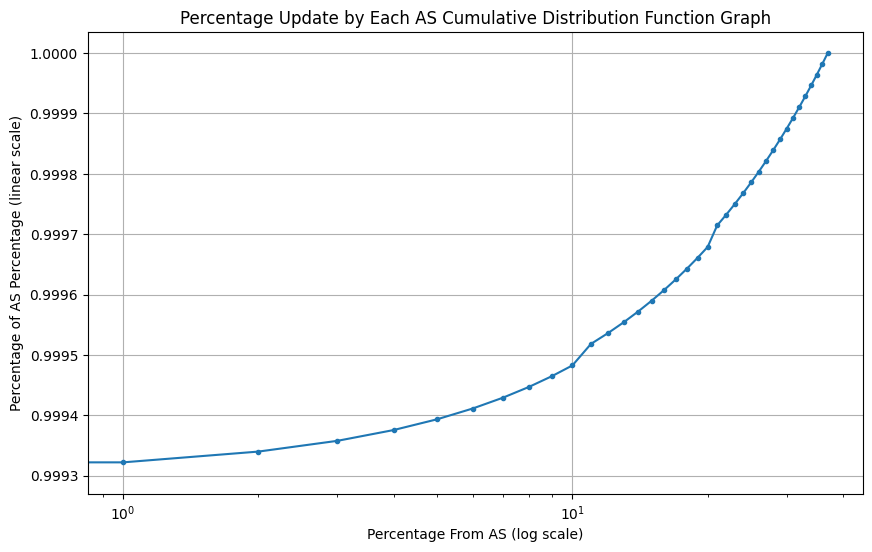

In [74]:
graph_cdf(calibrated_cdf, x_label='Percentage From AS (log scale)', y_label='Percentage of AS Percentage (linear scale)', plot_name='Percentage Update by Each AS Cumulative Distribution Function Graph',
          x_is_log=True, y_is_log=False, manipulate_x_ticks=False, continuous=True)

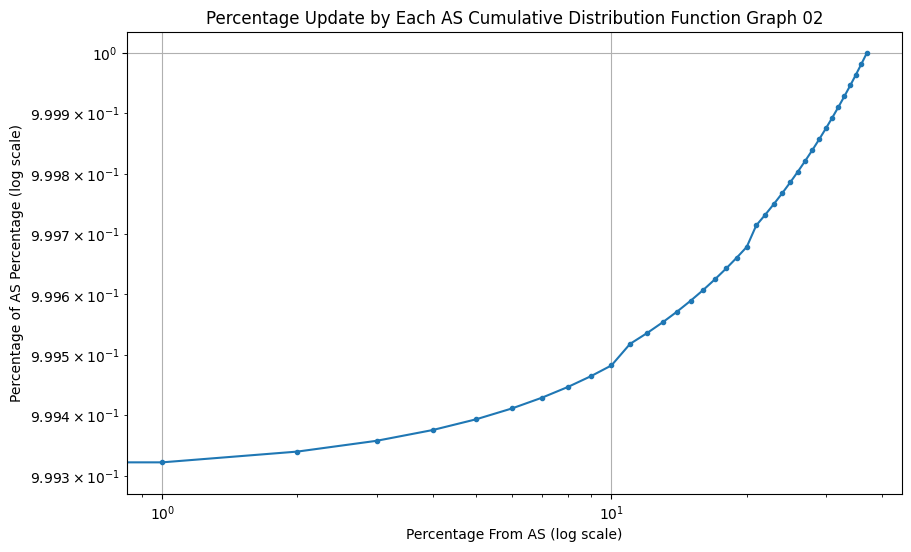

In [73]:
graph_cdf(calibrated_cdf, x_label='Percentage From AS (log scale)', y_label='Percentage of AS Percentage (log scale)', plot_name='Percentage Update by Each AS Cumulative Distribution Function Graph 02',
          x_is_log=True, y_is_log=True, manipulate_x_ticks=False, continuous=True)